**Credit Risk Dataset**

This dataset contains columns simulating credit bureau data


In [3]:
# Data
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

#Import packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score,recall_score, f1_score, roc_curve,roc_auc_score
from sklearn.calibration import calibration_curve

**Exploratory Data Analysis**

In [4]:
#Read data
df =pd.read_csv('/content/credit_risk_dataset.csv')
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
df.shape

(32581, 12)

In [6]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [8]:
# Summary statistics:
print(df.describe())

         person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%   

There are unexpected values for columns person_age and person_emp_length

In [9]:
# Look at Summary statistics for categorical features
df.describe(include= "object").T

,count,unique,top,freq
person_home_ownership,32581,4,RENT,16446
loan_intent,32581,6,EDUCATION,6453
loan_grade,32581,7,A,10777
cb_person_default_on_file,32581,2,N,26836


In [10]:
# Check and remove Duplicates
print(df.duplicated().value_counts())
df.drop_duplicates(inplace =True)

False    32416
True       165
Name: count, dtype: int64


In [11]:
#Check Missing Data
print(df.isnull().sum()) # 2 columns contains missing values

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [12]:
#Handle missing values
# The interest rate of loan depends on the bank => we can use the average value to fill in the missing values
df['loan_int_rate'] = df['loan_int_rate'].fillna( df['loan_int_rate'].median())
# The number of missing values in column "person_emp_length" is only 2.74% - we can drop them.
df.dropna(inplace = True)
df.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_status,0
loan_percent_income,0


Exploring data distribution

                       count   in %
person_home_ownership              
RENT                   16011  50.78
MORTGAGE               13021  41.30
OWN                     2391   7.58
OTHER                    106   0.34




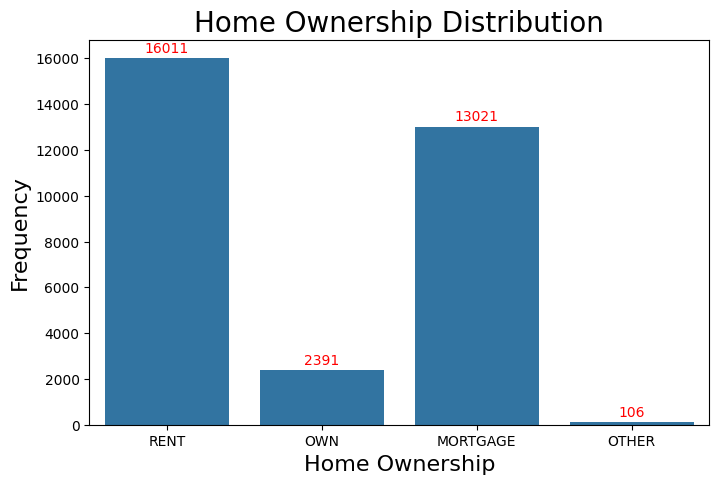



                   count   in %
loan_intent                    
EDUCATION           6248  19.82
MEDICAL             5869  18.61
VENTURE             5521  17.51
PERSONAL            5348  16.96
DEBTCONSOLIDATION   5044  16.00
HOMEIMPROVEMENT     3499  11.10




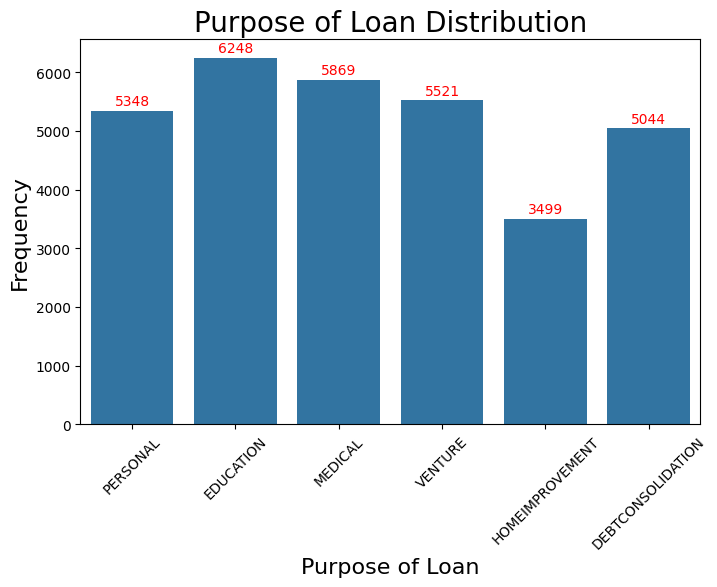



            count   in %
loan_grade              
A           10301  32.67
B           10124  32.11
C            6303  19.99
D            3550  11.26
E             951   3.02
F             236   0.75
G              64   0.20




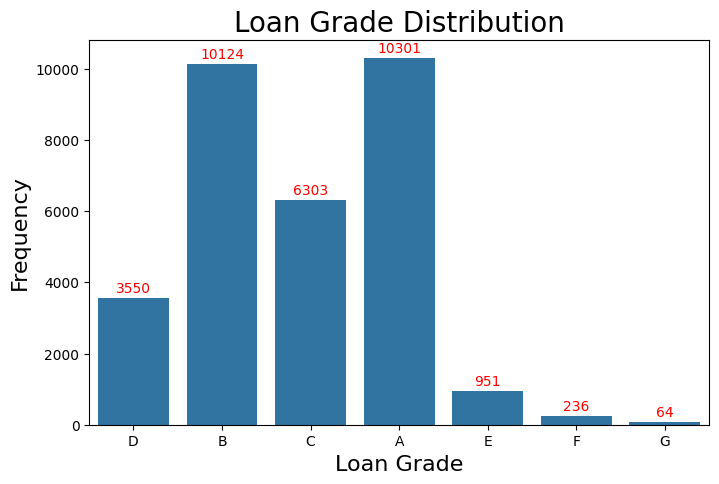



                           count   in %
cb_person_default_on_file              
N                          25914  82.19
Y                           5615  17.81




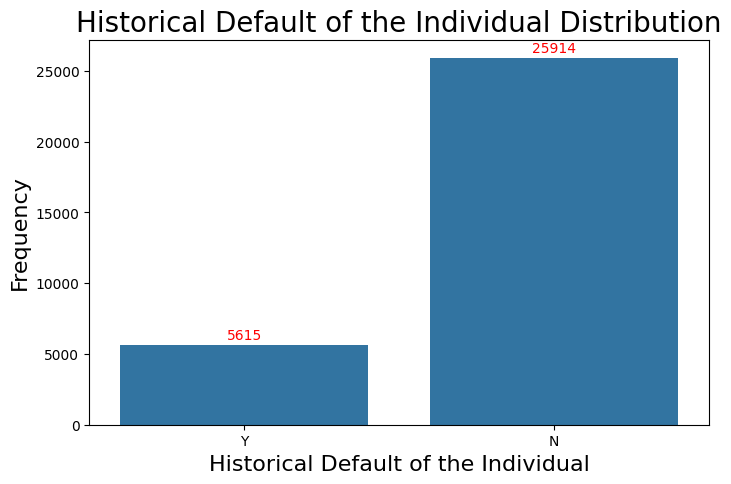

In [13]:
#Exploring categorical features  => The Data are imbalanced
cat_features = df.select_dtypes(include=['object'])
cat_x_labels = ["Home Ownership", "Purpose of Loan", "Loan Grade", "Historical Default of the Individual"]
cat_title =  ["Home Ownership Distribution", "Purpose of Loan Distribution", "Loan Grade Distribution", "Historical Default of the Individual Distribution"]

for i ,k in enumerate(cat_features):

    feature =df[k].value_counts().reset_index().sort_values(by ="count",ascending=False)
    feature["in %"] = round(feature["count"]/df.shape[0]*100,2)
    print(feature.set_index(k))
    print("\n")
    fig, ax = plt.subplots(figsize=(8,5))
    sns.countplot(x = k, data = df, ax=ax)
    ax.bar_label(ax.containers[0], padding = 2,color = "red",fontsize = 10)
    ax.set_xlabel(cat_x_labels[i],fontsize = 16)
    ax.set_ylabel('Frequency',fontsize = 16)
    ax.set_title(cat_title[i], fontsize = 20)
    if i==1:
        ax.tick_params(axis = "x", rotation=45)
    plt.show()
    print("\n")

Observation:
  - Most people, who takes a credit has a rent house(50.78%) or have a mortgage(41.30%)
  - The most common loan intent is EDUCATION (18.62%), the least common loan intent is HOME IMPROVEMENT (11.1%)
  - The majority of loans have a grade of A or B (~32%), which may indicate that these are the most favorable or desirable loan options. Loans with grades E, F, or G (<3%) may be considered riskier or less desirable.
  - The majority of individuals in the dataset are not defaulting on their loans (82.19%), but there is a significant number of individuals (around 17.81%) who are defaulting on their loans.
  
Based on the output, the categories are not evenly distributed:some categories being significantly more common than others. This could suggest that the sample may be biased towards certain specific individuals who are more likely to need credits and who are more likely to be granted credits.


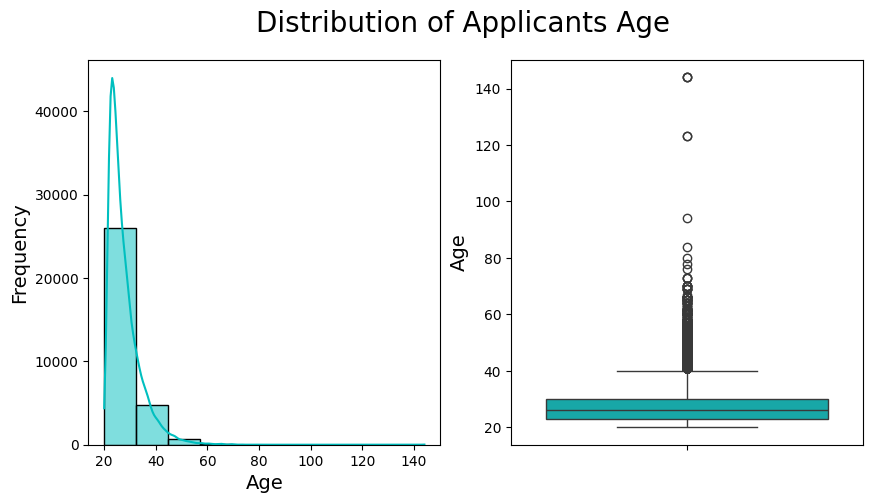

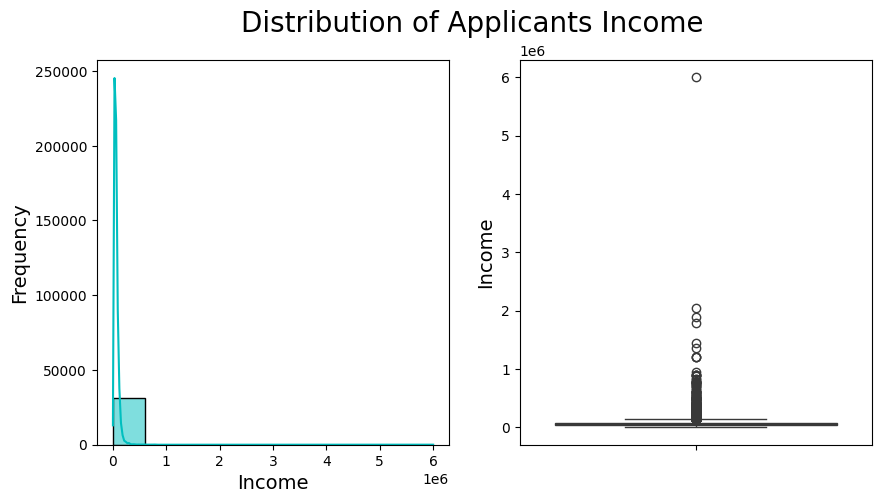

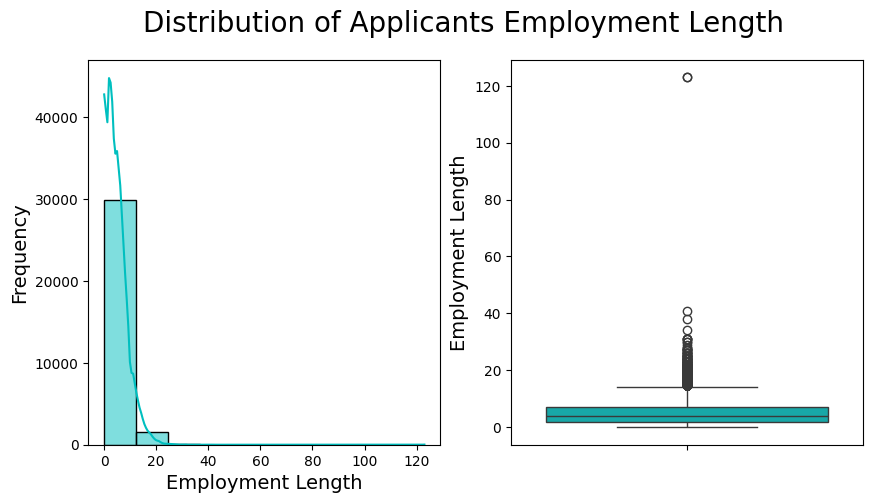

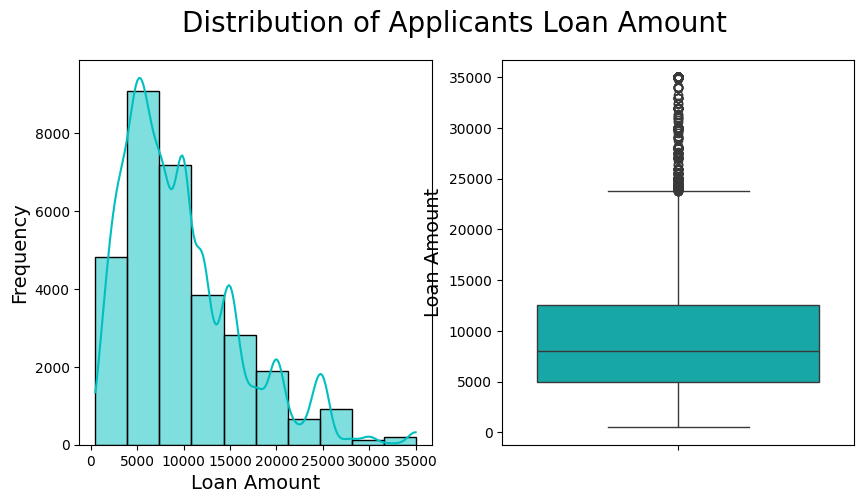

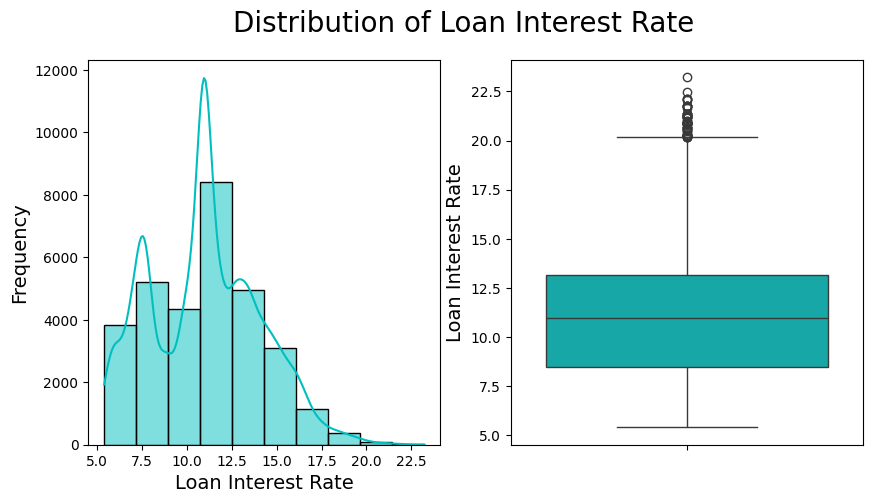

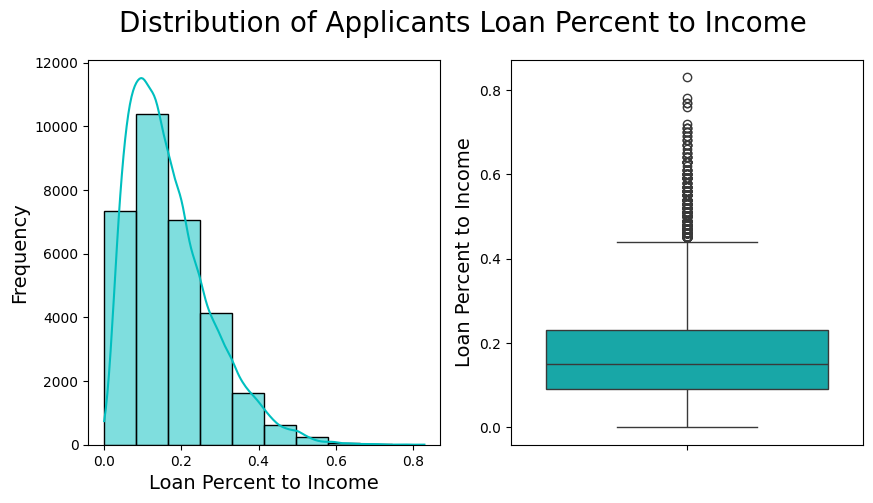

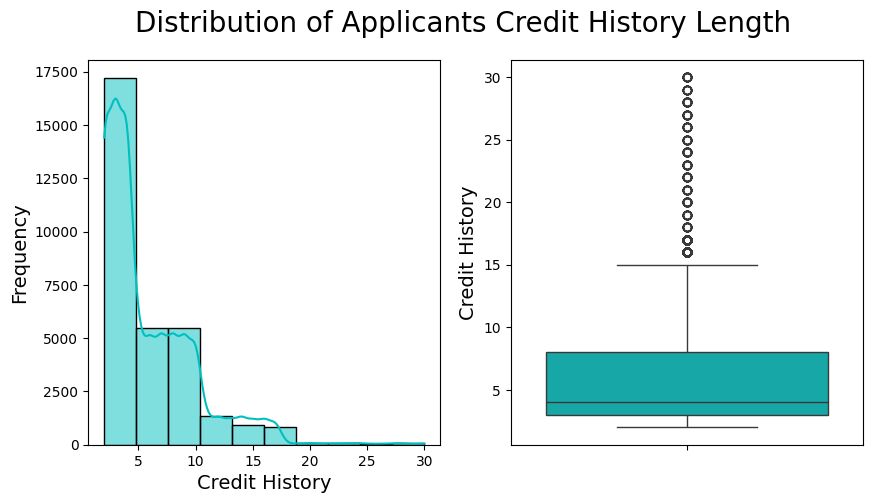

In [14]:
#Exploring numerical features
df_num_features = df.select_dtypes(include=['float64', 'int64']).drop("loan_status", axis = 1)
num_features = df_num_features.columns
num_x_labels=["Age","Income","Employment Length", "Loan Amount", "Loan Interest Rate", "Loan Percent to Income","Credit History"]
num_titles=["Distribution of Applicants Age", "Distribution of Applicants Income","Distribution of Applicants Employment Length","Distribution of Applicants Loan Amount", "Distribution of Loan Interest Rate","Distribution of Applicants Loan Percent to Income", "Distribution of Applicants Credit History Length"]
for i, k in enumerate(num_features):
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    plt.suptitle(num_titles[i], fontsize =20)

    sns.histplot(x= k, data = df, kde = True, color = "c", bins = 10, ax =axs[0])
    axs[0].set_xlabel(num_x_labels[i],fontsize =14)
    axs[0].set_ylabel('Frequency',fontsize =14)

    sns.boxplot(y= k, data = df, color ="c", ax =axs[1])
    axs[1].set_ylabel(num_x_labels[i], fontsize =14)

    plt.subplots_adjust(wspace=0.2, hspace=0.8)
    plt.show()


Observation:
  - The majority of borrowers are individuals between the ages of 20-30 with a low income and with employments length and credit history less than 10 years. The most popular loan amount ist 5.000-10.000$ with interest rates ranging from 7-13%.

All distribution are right skewed with long tail and have lots of outliers. It can lead to biased estimates of summary statistics and can affect the performance of the statistical models and the validity of assumptions in certain statistical tests and models.

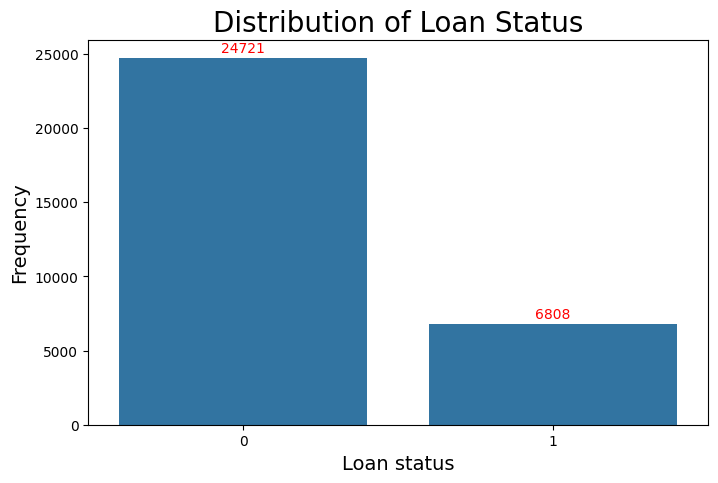

Non Default: 78.41 % of the dataset
Default: 21.59 % of the dataset


In [15]:
# Distribution of target variable

fig = plt.figure(figsize=(8,5))
ax = sns.countplot(x ='loan_status', data = df)
ax.bar_label(ax.containers[0], padding = 2, color = "red",fontsize = 10)
ax.set_xlabel("Loan status",fontsize = 14)
ax.set_ylabel("Frequency",fontsize = 14)
ax.set_title("Distribution of Loan Status", fontsize = 20)
plt.show()

print('Non Default:', round( df['loan_status'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Default:', round(df['loan_status'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Observation:

The majority of borrowers in the dataset (78.4%) have successfully paid back their loans without defaulting, while 21.6% have defaulted on their loans.

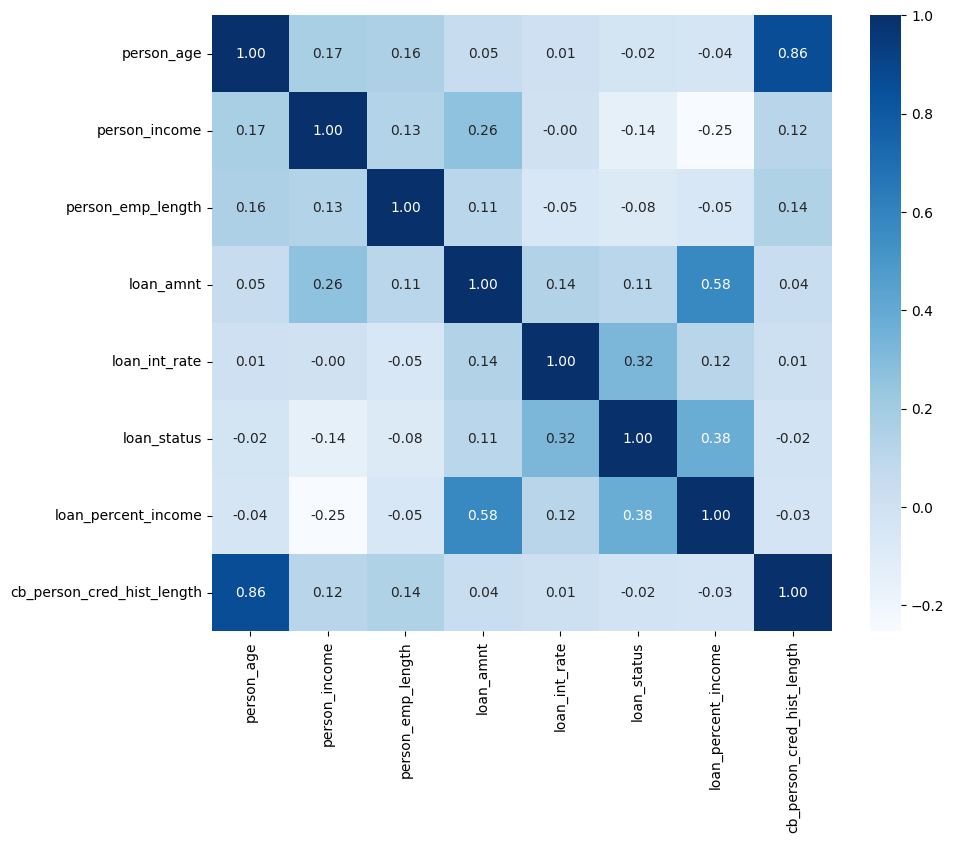

In [16]:
#Correlation Analysis
df_numeric = df.select_dtypes(include=['float64', 'int64'])
correlation = df_numeric.corr()
fig = plt.figure(figsize =(10,8))
sns.heatmap(correlation, cmap='Blues', annot=True, fmt='.2f')
plt.show()

Observation:
 - Person_age and person_cred_hist_length has a strong correlation (~86%), as expected. Older people tend to have longer credit histories, which is a natural consequence of aging.
  - Loan_person_income and loan_amount has a moderate correlation (~58%). As the loan amount increases, the proportion of income committed to the loan tends to increase, that is also expected.
  - Person_income and loan_amount: The relationship between income and loan amount is positive (week correlation ~26%), meaning that people with higher incomes tend to borrow more. This is also expected, because individuals with higher incomes have more financial resources to repay debt.

Negative effect on loan_status have person_income, person_emp_length, person_age and credit history. These variables have a positive impact on loan quality, making it less likely for borrowers with higher values of these variables to default on their loans.

Positive effect on loan_status have loan_percent_income, loan_int_rate, and loan_amnt. It means, that as they increase, the risk of default increases.

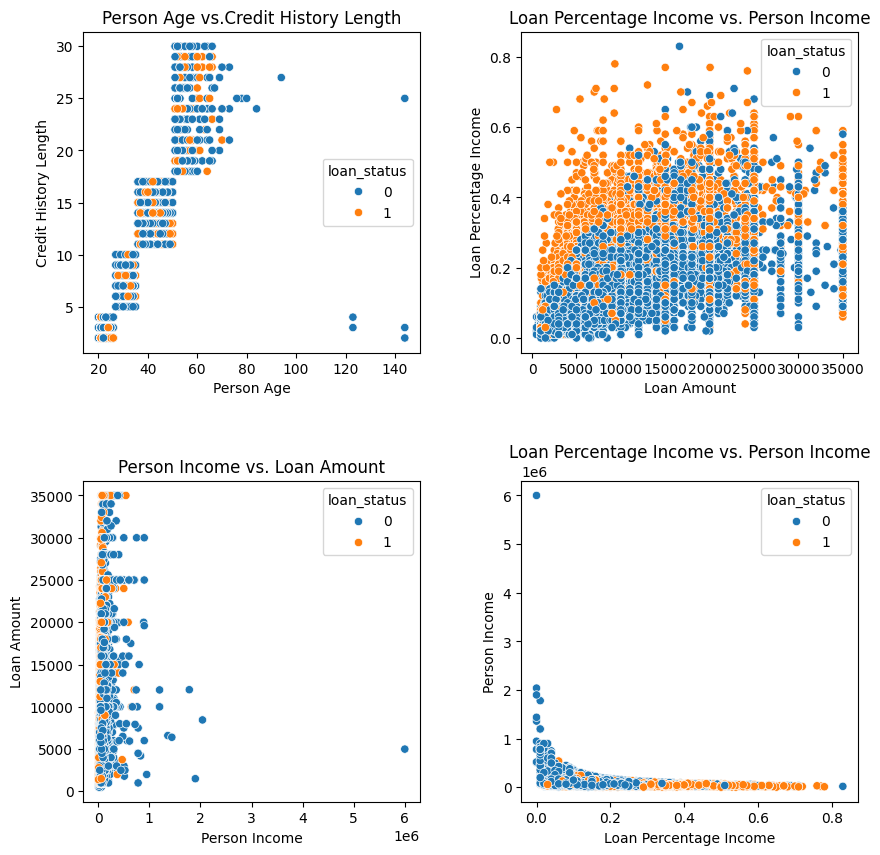

In [17]:
#Scatterplots for the correlating variables:

fig,axes =plt.subplots(2,2,figsize=(10,10))
x_labels=["Person Age","Loan Amount", "Person Income", "Loan Percentage Income"]
y_labels=["Credit History Length","Loan Percentage Income", "Loan Amount", "Person Income"]
titles=["Person Age vs.Credit History Length","Loan Percentage Income vs. Person Income", "Person Income vs. Loan Amount","Loan Percentage Income vs. Person Income"]
ax=[axes[0,0],axes[0,1],axes[1,0],axes[1,1]]
x =["person_age","loan_amnt","person_income","loan_percent_income"]
y=["cb_person_cred_hist_length","loan_percent_income","loan_amnt","person_income"]

for i in range(len(x_labels)):
    sns.scatterplot(x = x[i], y=y[i], data = df, hue = "loan_status", ax = ax[i])
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(x_labels[i])
    ax[i].set_ylabel(y_labels[i])

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

Observation:
  - There is a strong positive dependence between Person_age and Person_cred_hist_length: the older individuals tend to have longer credit histories.
  - The second and forth plots indicate that as "loan_percent_income" increases, the number of defaults tend to increase. This suggests that "loan_percent_income" is a strong predictor of loan default.
  - The third plot shows that individuals with higher incomes tend to borrow less and  have a lower risk of default. The individuals with lower incomes tend to borrow more and have a higher risk of default. This observation highlights the importance of considering income as a crucial factor in predicting loan default.

In [18]:
# loan_status
home_loan_status = pd.crosstab(index =df.person_home_ownership, columns =df.loan_status, margins = True)
home_loan_status.columns = ["not_default %", "default %", "total"]
home_loan_status["not_default %"] = round(home_loan_status["not_default %"]/home_loan_status["total"]*100,2)
home_loan_status["default %"] = round(home_loan_status["default %"]/home_loan_status["total"]*100,2)

home_ownership =df.groupby(["person_home_ownership","cb_person_default_on_file"])["loan_status"].sum().reset_index().sort_values(by = "loan_status",ascending = False)
home_ownership["loan_status_percent"] = home_ownership["loan_status"]/home_ownership["loan_status"].sum()
print("         Home ownership vs. Loan Status")
print(home_loan_status)
print("-----------------------------------------------------\n")

grade_loan_status = pd.crosstab(index =df.loan_grade, columns =df.loan_status, margins = True)
grade_loan_status.columns = ["not_default %", "default %", "total"]
grade_loan_status["not_default %"] = round(grade_loan_status["not_default %"]/grade_loan_status["total"]*100,2)
grade_loan_status["default %"] = round(grade_loan_status["default %"]/grade_loan_status["total"]*100,2)

loan_grade =df.groupby(["loan_grade","cb_person_default_on_file"])["loan_status"].sum().reset_index().sort_values(by = "loan_status",ascending = False)
loan_grade["loan_status_percent"] = loan_grade["loan_status"]/loan_grade["loan_status"].sum()

print("         Loan Grade vs. Loan Status")
print(grade_loan_status)
print("----------------------------------------------------\n")

intent_loan_status = pd.crosstab(index =df.loan_intent , columns =df.loan_status, margins = True)
intent_loan_status.columns = ["not_default %", "default %", "total"]
intent_loan_status["not_default %"] = round(intent_loan_status["not_default %"]/intent_loan_status["total"]*100,2)
intent_loan_status["default %"] = round(intent_loan_status["default %"]/intent_loan_status["total"]*100,2)

loan_intent =df.groupby(["loan_intent","cb_person_default_on_file"])["loan_status"].sum().reset_index().sort_values(by = "loan_status",ascending = False)
loan_intent["loan_status_percent"] = loan_intent["loan_status"]/loan_intent["loan_status"].sum()

print("        Loan Intent vs. Loan Status")
print(intent_loan_status)
print("----------------------------------------------------\n")


default_on_file_loan_status = pd.crosstab(index =df.cb_person_default_on_file , columns =df.loan_status, margins = True)
default_on_file_loan_status.columns = ["not_default %", "default %", "total"]
default_on_file_loan_status["not_default %"] = round(default_on_file_loan_status["not_default %"]/default_on_file_loan_status["total"]*100,2)
default_on_file_loan_status["default %"] = round(default_on_file_loan_status["default %"]/default_on_file_loan_status["total"]*100,2)

print("        Historical default of the individual  vs. Loan Status")
print(default_on_file_loan_status)
print("----------------------------------------------------\n")

         Home ownership vs. Loan Status
                       not_default %  default %  total
person_home_ownership                                 
MORTGAGE                       87.50      12.50  13021
OTHER                          68.87      31.13    106
OWN                            93.06       6.94   2391
RENT                           68.88      31.12  16011
All                            78.41      21.59  31529
-----------------------------------------------------

         Loan Grade vs. Loan Status
            not_default %  default %  total
loan_grade                                 
A                   90.44       9.56  10301
B                   84.04      15.96  10124
C                   79.69      20.31   6303
D                   41.21      58.79   3550
E                   35.75      64.25    951
F                   29.66      70.34    236
G                    1.56      98.44     64
All                 78.41      21.59  31529
--------------------------------------------

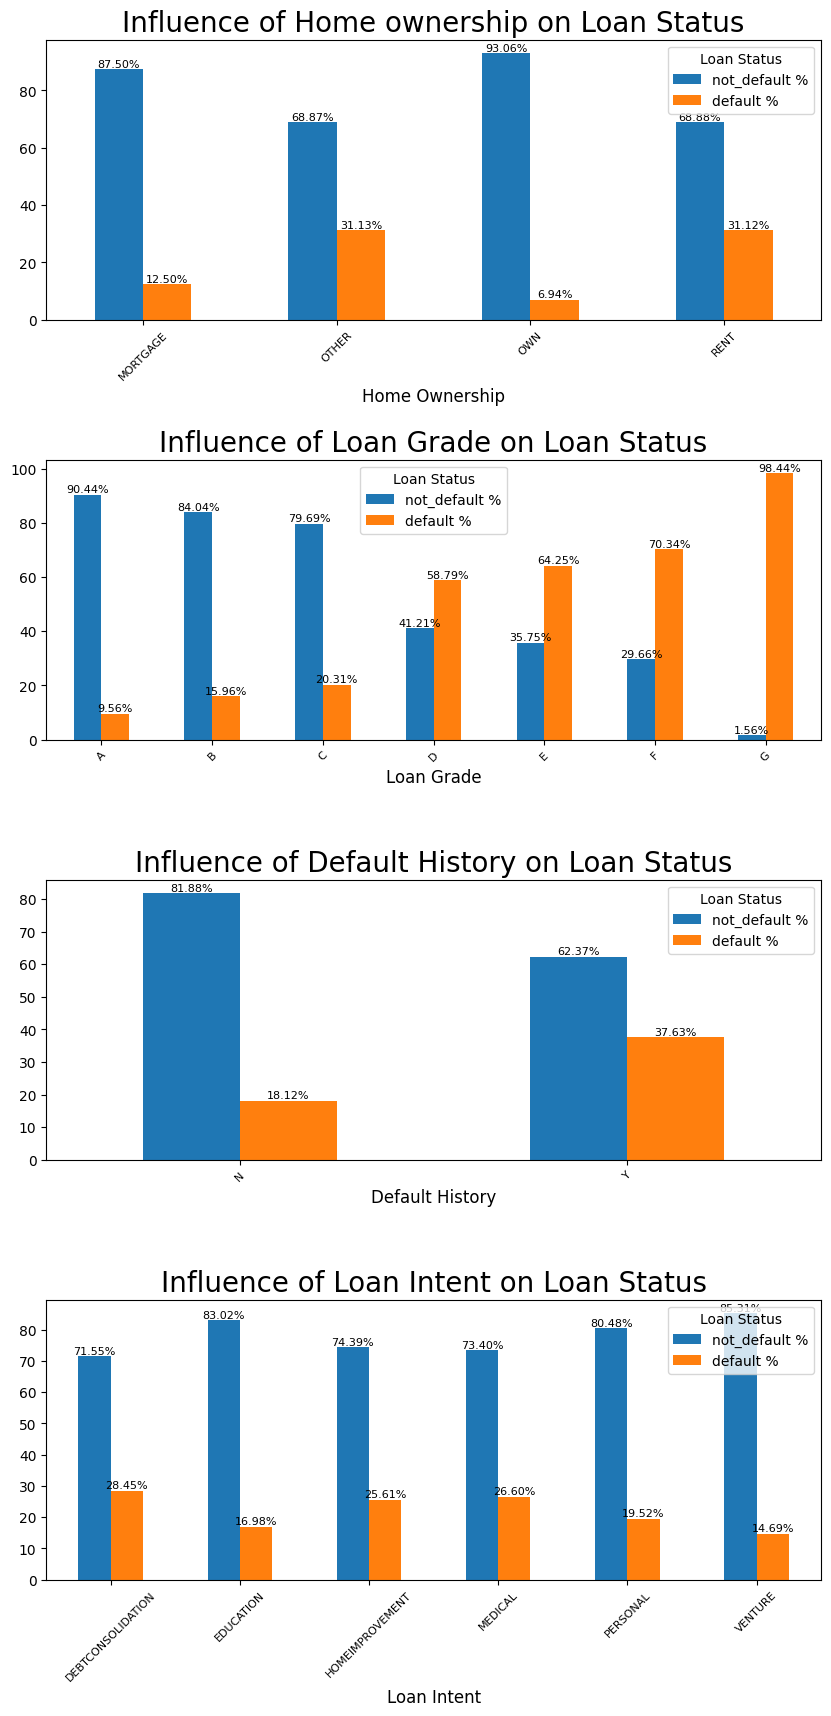

In [19]:
fig,axes = plt.subplots(4,1,figsize=(10,20))
x_labels=["Home Ownership","Loan Grade",  "Default History","Loan Intent"]
titles=["Influence of Home ownership on Loan Status","Influence of Loan Grade on Loan Status", "Influence of Default History on Loan Status","Influence of Loan Intent on Loan Status"]
x1 =[home_loan_status,grade_loan_status,default_on_file_loan_status, intent_loan_status]

for i in range(len(x_labels)):
    x1[i].iloc[:-1,0:2].plot.bar( ax=axes[i])
    axes[i].set_xlabel(x_labels[i],fontsize = 12)
    axes[i].set_title(titles[i],fontsize = 20)
    axes[i].legend( title='Loan Status')
    for p in axes[i].patches:
        axes[i].text(p.get_x() + p.get_width()/2., p.get_height(), f"{p.get_height():.2f}%", ha='center', va='bottom',fontsize = 8)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, fontsize =8)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

Observation:
   - The overall default rate for all individuals is 21.60%.
   - Home owners (MORTGAGE, OWN) tend to have a lower loan default rate compared to renters (RENT) and those with other types of home ownership (OTHER). These findings can suggest that owning a home or having a mortgage might be associated with a lower risk of loan default compared to renting or having other types of home ownership.
   - Loans with a grade A have the highest non-default rate (90.44%) and the lowest default rate (9.56%). Loans with a grade F have the lowest non-default rate (29.66%) and the highest default rate (70.34%). As you move from higher-grade loans (A, B, C) to lower-grade loans (D, E, F), the non-default rate decreases, while the default rate increases. It can mean, that higher-grade loans are less likely to default, while lower-grade loans are more likely to default.
   - Individuals who already has default history  have a higher default rate of 37.62%, compared to those who doesn't have (18.12%). It can mean that individuals with positive default history may be more likely to default on their loans.
   - The loan intent categories with the highest proportion of loans that are in default are DEBTCONSOLIDATION (28.45%), HOMEIMPROVEMENT(25.61%) and MEDICAL (26.60%). They have a higher risk of default, while loans for education (EDUCATION) and venture purposes (VENTURE) have a lower risk of default (16.99% and 14.70%, respectively).

In [20]:
# Create new categories to reduce the impact outliers
# Create age categories
bins = [-1,20,30,40,50,60,70, 1000]
labels = ["0-20","20-30","30-40","40-50","50-60","60-70","70+"]
df["age_category"] = pd.cut(df["person_age"], bins = bins, labels = labels)
age_category = df["age_category"].value_counts().reset_index()
print(age_category.set_index("age_category"))
print("----------------------------------------------------\n")

# Create person_emp_length categories
bins = [-1,5,10,15,1000]
labels = ["0-5","5-10","10-15","15+"]
df["person_emp_length_category"] = pd.cut(df["person_emp_length"], bins = bins, labels = labels)
person_emp_length_category = df["person_emp_length_category"].value_counts().reset_index()
print(person_emp_length_category.set_index("person_emp_length_category"))
print("----------------------------------------------------\n")

# Create person_income categories
bins = [0,25000,50000,75000,100000,5000000]
labels = ["0-25000","25000-50000","50000-75000","75000-100000","100000+"]
df["person_income_category"] = pd.cut(df["person_income"], bins = bins, labels = labels)
person_income_category = df["person_income_category"].value_counts().reset_index()
print(person_income_category.set_index("person_income_category"))
print("----------------------------------------------------\n")

# Create loan_amount categories
bins = [0,5000,10000,15000,20000, 100000]
labels = ["0-5000","5000-10000","10000-15000","15000-20000","20000+"]
df["loan_amnt_category"] = pd.cut(df["loan_amnt"], bins = bins, labels = labels)
loan_amnt_category = df["loan_amnt_category"].value_counts().reset_index()
print(loan_amnt_category.set_index("loan_amnt_category"))
print("----------------------------------------------------\n")

# Create hist_length_category categories
bins = [0,5,10,15,100]
labels = ["0-5","5-10","10-15","15+"]
df["cb_person_cred_hist_length_category"] = pd.cut(df["cb_person_cred_hist_length"], bins = bins, labels = labels)
cb_person_cred_hist_length_category = df["cb_person_cred_hist_length_category"].value_counts().reset_index()
print(cb_person_cred_hist_length_category.set_index("cb_person_cred_hist_length_category"))
print("----------------------------------------------------\n")

              count
age_category       
20-30         23968
30-40          6089
40-50          1173
50-60           215
60-70            56
0-20             15
70+              13
----------------------------------------------------

                            count
person_emp_length_category       
0-5                         20046
5-10                         8565
10-15                        2304
15+                           614
----------------------------------------------------

                        count
person_income_category       
25000-50000             11177
50000-75000              9406
75000-100000             4595
100000+                  4150
0-25000                  2200
----------------------------------------------------

                    count
loan_amnt_category       
5000-10000          11658
0-5000               9025
10000-15000          5989
15000-20000          2753
20000+               2104
----------------------------------------------------

        

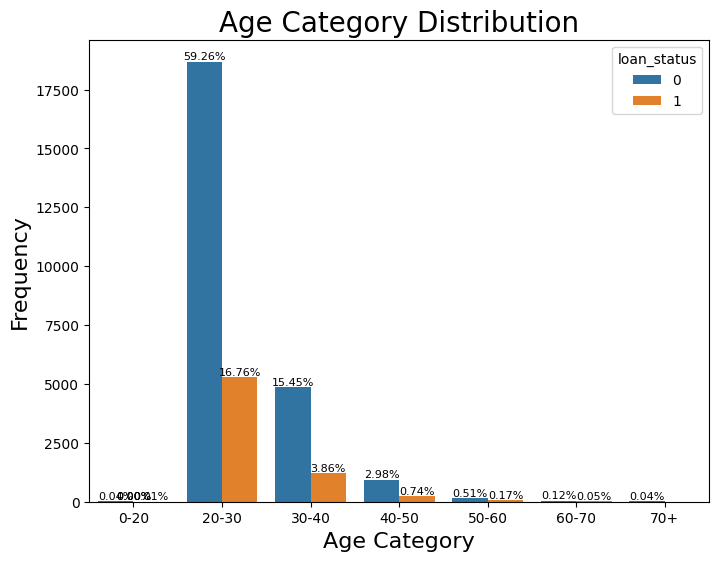

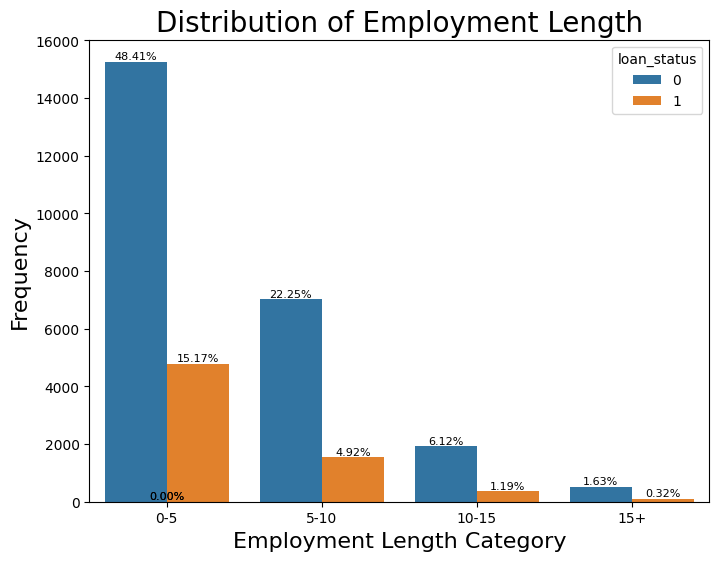

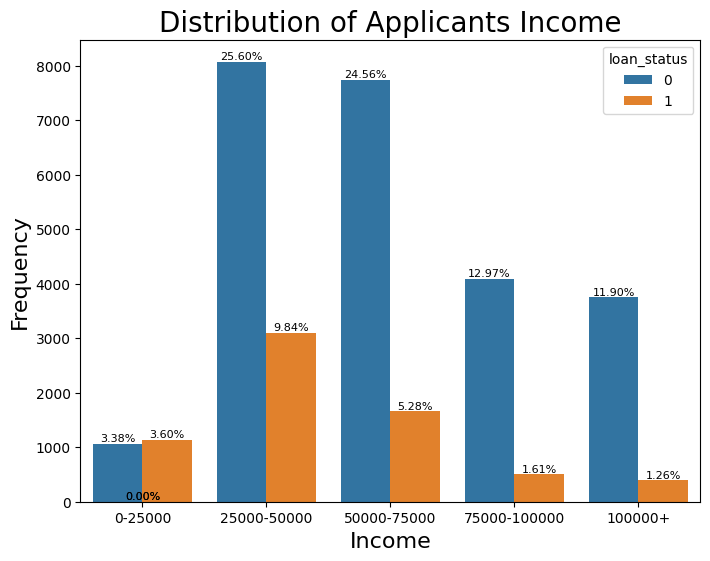

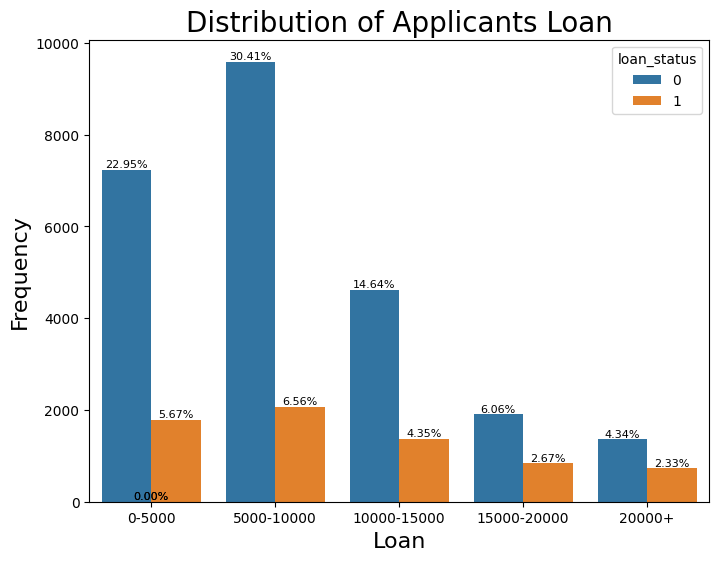

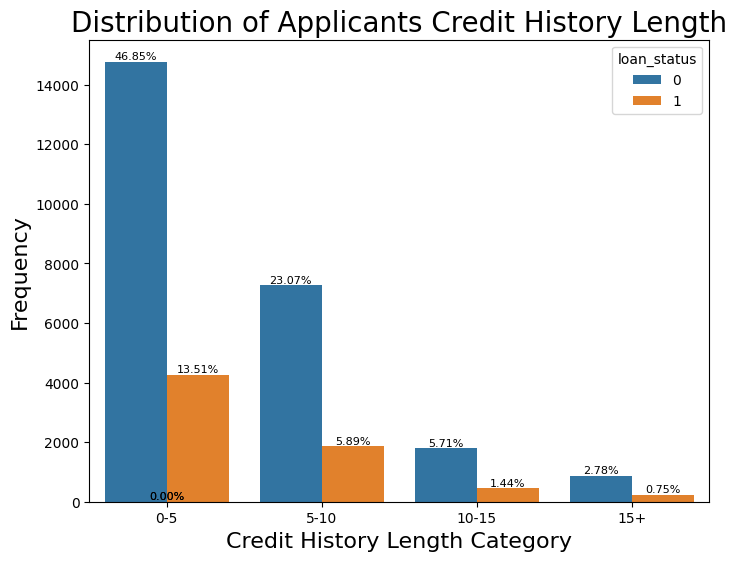

In [21]:
x =["age_category","person_emp_length_category","person_income_category","loan_amnt_category","cb_person_cred_hist_length_category"]
titles =["Age Category Distribution","Distribution of Employment Length","Distribution of Applicants Income","Distribution of Applicants Loan","Distribution of Applicants Credit History Length"]
x_labels = ["Age Category",'Employment Length Category',"Income","Loan","Credit History Length Category"]

for i in range(len(x)):
    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot()
    sns.countplot(x= x[i], data = df, hue = "loan_status", ax= ax)
    plt.title(titles[i], fontsize =20)
    plt.xlabel(x_labels[i],fontsize =16)
    plt.ylabel('Frequency', fontsize =16)
    total_count = df.shape[0]
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,height+1, f"{height/total_count*100:.2f}%", ha = 'center', va = 'bottom', fontsize = 8)
plt.show()

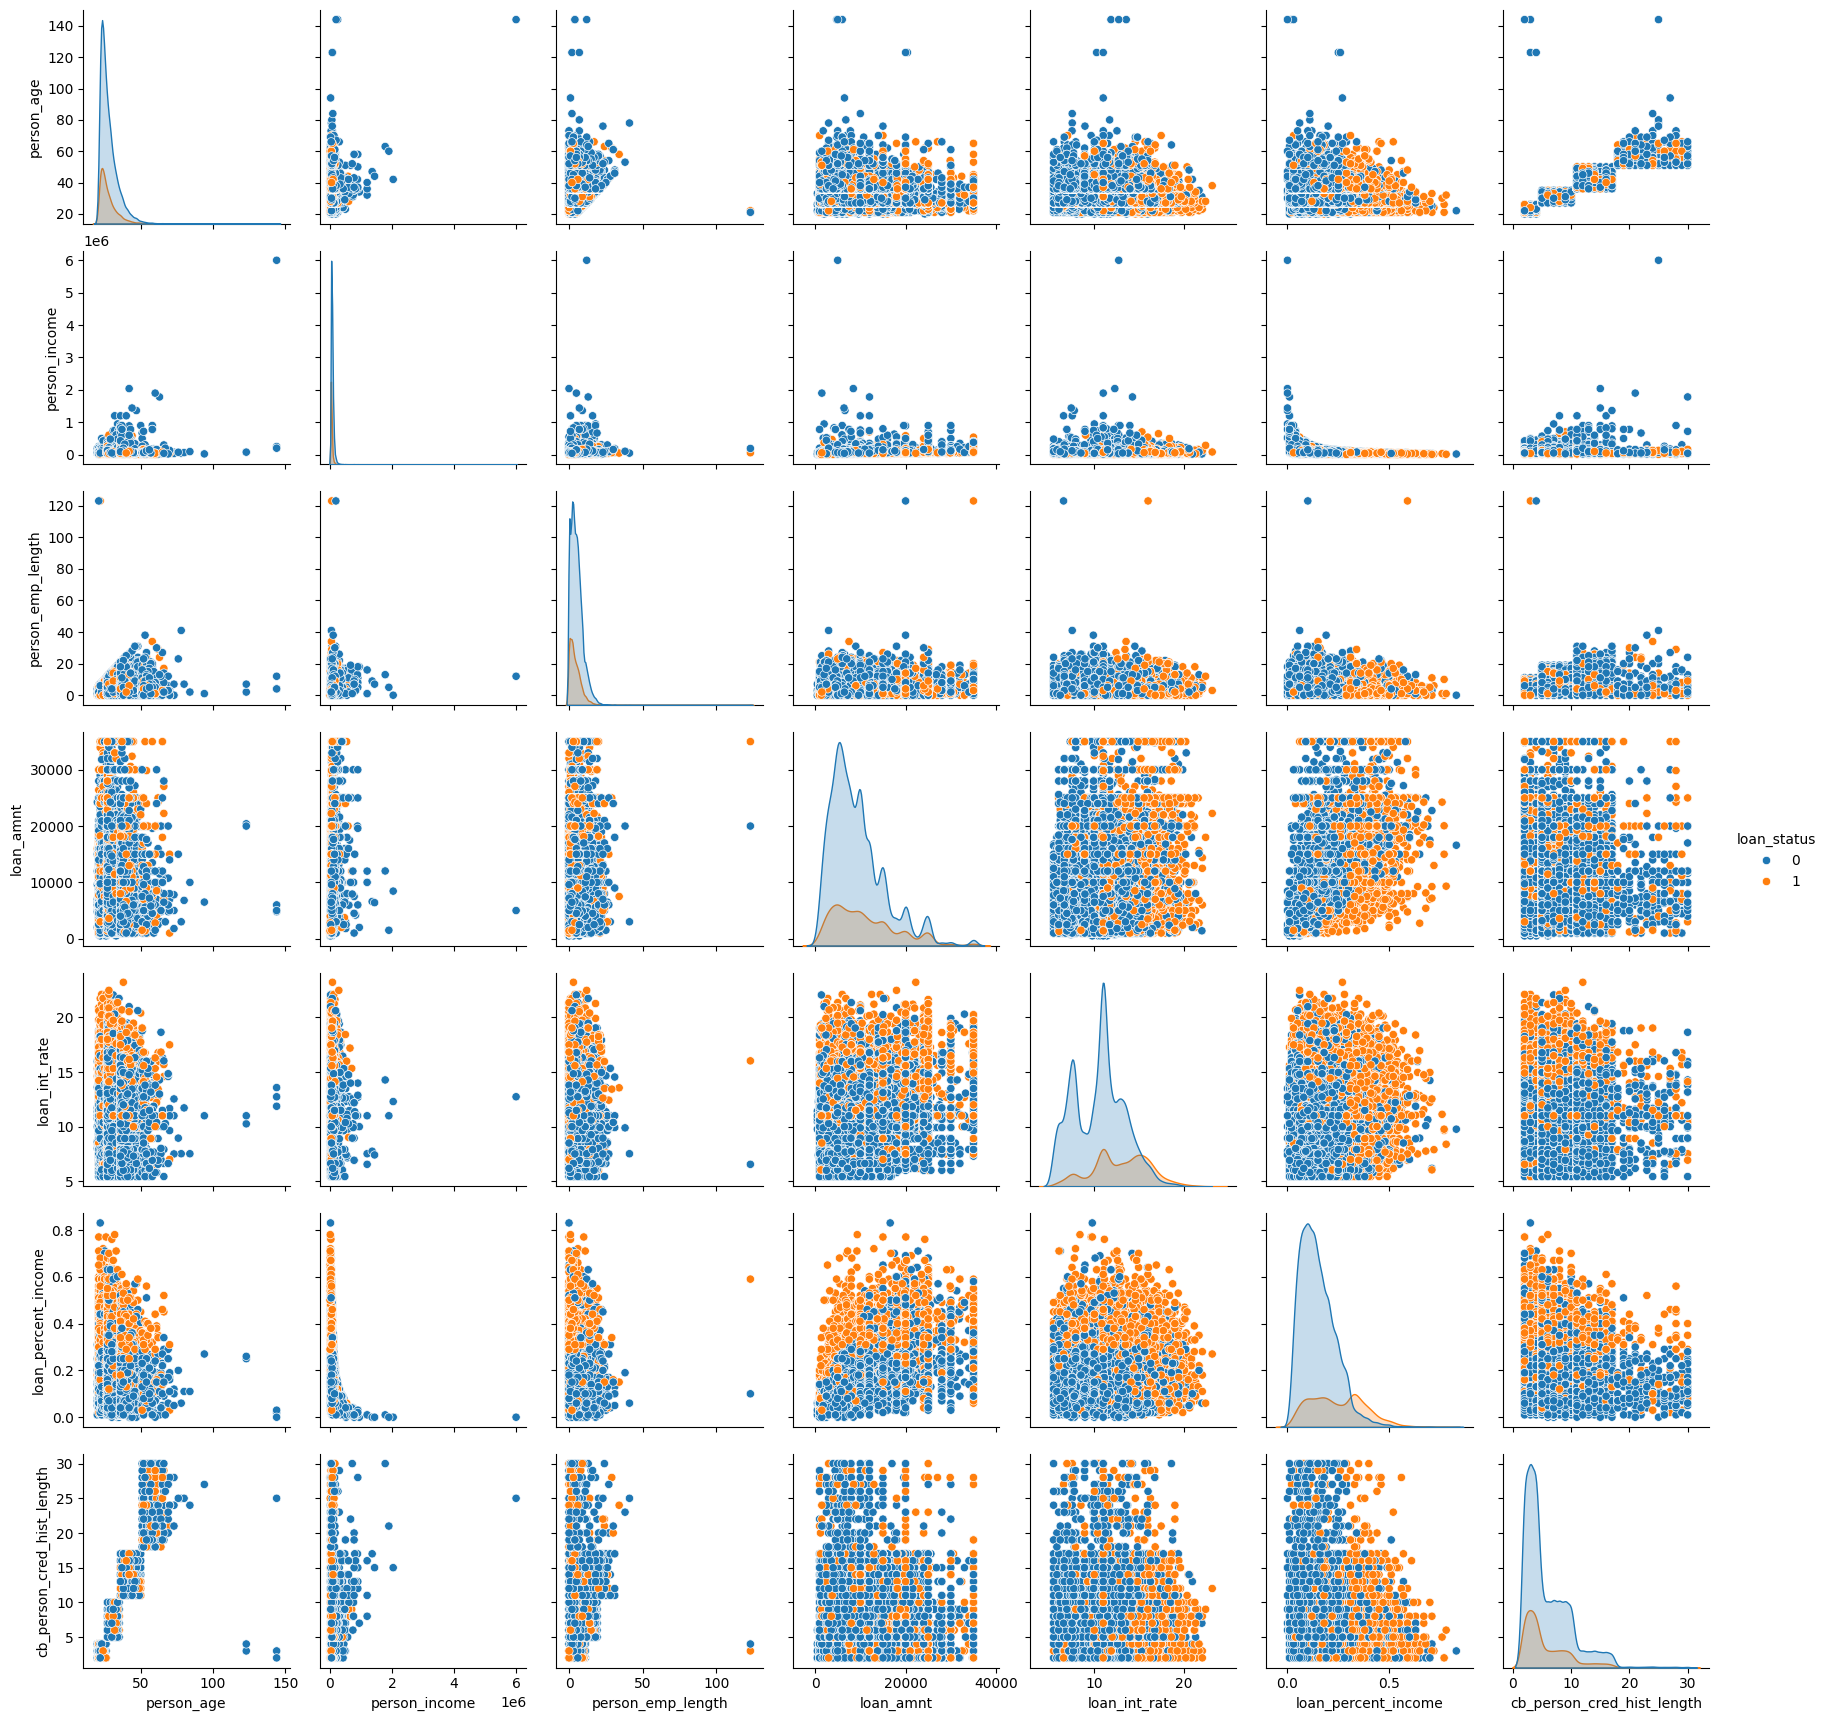

In [22]:
# General look at all plots
sns.pairplot(df,hue="loan_status")

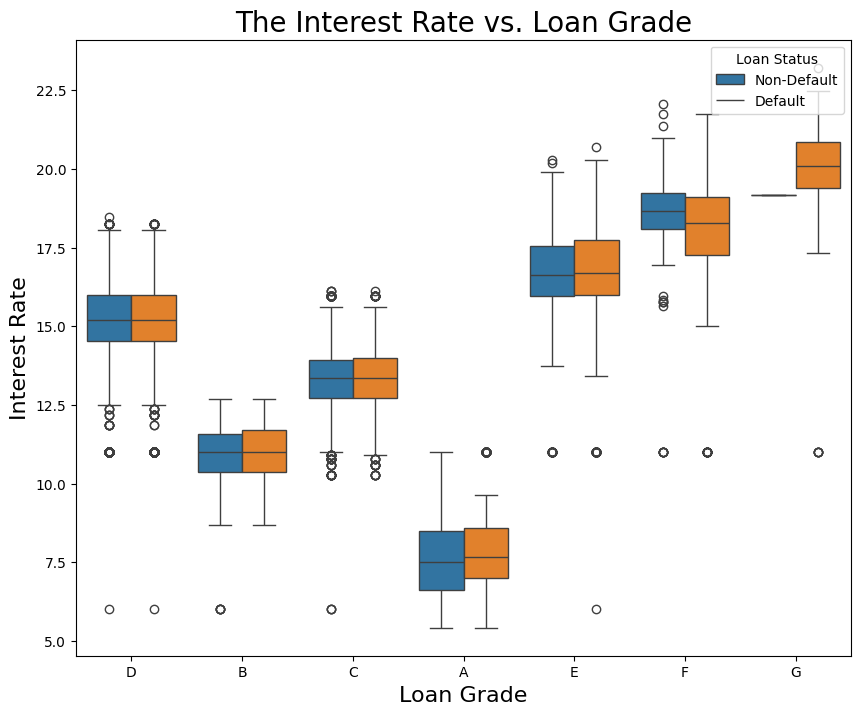

In [23]:
# Additional plots
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='loan_grade', y='loan_int_rate', hue='loan_status')
plt.title('The Interest Rate vs. Loan Grade', fontsize =20)
plt.xlabel('Loan Grade',fontsize =16)
plt.ylabel('Interest Rate', fontsize =16)
plt.legend(title='Loan Status', loc='upper right', labels=['Non-Default', 'Default'])
plt.show()

Observation:
 - There is a relationship between Loan Grade and Loan Interest Rate: loans with lower grades (riskier) tend to have higher interest rates, while loans with higher grades (less risky) tend to have lower interest rates.

**Feature Engineering**

In [24]:
# Removing unnecessary columns and separate independent variables and target variable.
X = df.drop(
    ["loan_status", "person_age", 'person_income', 'person_emp_length', 'cb_person_cred_hist_length'],
    axis=1)
y = df["loan_status"]
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 31529 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   person_home_ownership                31529 non-null  object  
 1   loan_intent                          31529 non-null  object  
 2   loan_grade                           31529 non-null  object  
 3   loan_amnt                            31529 non-null  int64   
 4   loan_int_rate                        31529 non-null  float64 
 5   loan_percent_income                  31529 non-null  float64 
 6   cb_person_default_on_file            31529 non-null  object  
 7   age_category                         31529 non-null  category
 8   person_emp_length_category           31529 non-null  category
 9   person_income_category               31528 non-null  category
 10  loan_amnt_category                   31529 non-null  category
 11  cb_person_cred_hist_

In [25]:
# Spliting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)
print(X_train.shape,X_test.shape)

(25223, 12) (6306, 12)


In [26]:
# Encode categorical variables
label_encoder = LabelEncoder()

X_train_categorical = X_train.select_dtypes(include=['object','category'])
X_test_categorical = X_test.select_dtypes(include=['object','category'])

# With LabelEncoder()
for column in X_train_categorical.columns:
    X_train_categorical[column] = label_encoder.fit_transform(X_train_categorical[column])
    X_test_categorical[column] = label_encoder.transform(X_test_categorical[column])

In [27]:
# Scaling categorical and numerical variables
scalar = StandardScaler()
X_train_numerical = X_train.select_dtypes(include=['int64','float64'])
X_test_numerical  = X_test.select_dtypes(include=['int64','float64'])

X_train_numerical["loan_int_rate"] =scalar.fit_transform( X_train_numerical[["loan_int_rate"]])
X_test_numerical["loan_int_rate"] =scalar.transform( X_test_numerical[["loan_int_rate"]])

In [28]:
# Concatenate scaling numerical variables
X_train =pd.concat([X_train_categorical, X_train_numerical], axis = 1)
X_test =pd.concat([X_test_categorical,X_test_numerical], axis = 1)

X_train_loan_amount = X_train['loan_amnt']
X_test_loan_amount = X_test['loan_amnt']

X_train =X_train.drop('loan_amnt', axis=1)
X_test =X_test.drop('loan_amnt', axis=1)

In [29]:
#Check Multicollinearity for Logistic Regression
vif_data = pd.DataFrame()
vif_data['index'] = X_train.columns
vif_data["Vif_train"] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif_data["Vif_test"] = [variance_inflation_factor(X_test.values,i) for i in range(X_test.shape[1])]
print(vif_data)

                                  index  Vif_train  Vif_test
0                 person_home_ownership   2.355455  2.324992
1                           loan_intent   2.851078  2.970726
2                            loan_grade   8.881031  8.836036
3             cb_person_default_on_file   1.706134  1.727980
4                          age_category   5.319685  5.253817
5            person_emp_length_category   1.534920  1.498804
6                person_income_category   4.454832  4.481323
7                    loan_amnt_category   2.564510  2.517169
8   cb_person_cred_hist_length_category   1.773547  1.750014
9                         loan_int_rate   3.936106  3.909907
10                  loan_percent_income   3.556204  3.548087


Observation:

There are features (loan_grade, age_category) with VIF >=5 => potentially problem with Multicollinearity
Solutions:
   - delete column loan_grade
   - use regularization (Lasso or Ridge) for LogisticRegression (will use this)
   - use PCA - principal component analysis for dimensionally reduction

**Model training**

In [30]:
#  Create a function for hyperparameter tuning and selecting the best model with the best hyperparameters
def tuning_params_randomized(param_grid, model, X_train, y_train):
    # Perform randomized search with KFold cross-validation
    kf = KFold(n_splits=6, shuffle=True, random_state=42)
    random_model = RandomizedSearchCV(
        estimator=model, param_distributions=param_grid, scoring="accuracy", cv=kf, n_jobs=-1, n_iter=10
    )  # n_iter controls the number of random combinations to try
    random_model.fit(X_train, y_train)
    best_params = random_model.best_params_
    best_score = random_model.best_score_
    best_model = random_model.best_estimator_
    test_accuracy = best_model.score(X_test, y_test)

    print("--------------------------")
    print("Best Hyperparameters RandomizedSearchCV:", best_params)
    print("Best Score RandomizedSearchCV:", best_score)
    print("Best Test accuracy: ", test_accuracy)
    print("\n")
    return best_model

In [31]:
# Create a function for models evaluation
def predict_evaluation(model, X_test, y_test):
    # Make predictions on the testing data
    y_predict = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1score = f1_score(y_test, y_predict)

    print('Accuracy predict: %.2f%%' % (accuracy * 100.0))
    print('Precision: %.2f%%' % (precision * 100.0))
    print('Recall: %.2f%%' % (recall * 100.0))
    print('F1_score: %.2f%%' % (f1score * 100.0))
    print("----------------------")

    # Create a list of evaluation metrics
    model_scores = []
    model_scores.append(accuracy)
    model_scores.append(precision)
    model_scores.append(recall)
    model_scores.append(f1score)

    # Print classification report
    print("Сlassification report:")
    print(classification_report(y_test, y_predict))
    print("----------------------")

    # Plot confusion matrix
    print("Confusion matrix:")
    cm = confusion_matrix(y_test, y_predict)
    print(cm)
    print("----------------------")

    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix(y_test, y_predict), annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.title("Confusion Matrix", fontsize=14, fontweight='bold')
    plt.show()

    # Result
    model_result = [y_predict, model_scores]

    return  model_result

In [32]:
# Predict probabilities function - create ROC curve
def roc_function(model, X_test, y_test):

    # predict probabilities of each instance belonging to positive class
    y_predict_probability = model.predict_proba(X_test)[:, 1]
    #to visualize how different thresholds affect true positive and false positive rates.
    fpr, tpr, thresholds = roc_curve(y_test, y_predict_probability)

    #Estimate AUC metric - calculate the area under the ROC curve
    print("----------------------")
    auc = roc_auc_score(y_test, y_predict_probability)*100
    print('AUC: %.2f%%' % (auc))
    print("----------------------")

    plt.plot(fpr, tpr, color='blue')
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel('False Positive Rate', fontsize = 16)
    plt.ylabel('True Positive Rate',fontsize = 16)
    plt.title(f'ROC Curve',fontsize = 20)
    #plt.show()

    return auc

In [33]:
# Define hyperparameter grid

param_grid = {
    "knn" : {'n_neighbors': np.arange(1,16),'p': [1, 2]},
    "logreg" : { 'C': [0.1, 1, 10],  # regularization strength
               'penalty': ['l1', 'l2'],  # L1/L2 regularization
               "max_iter": [1000, 2000, 3000] },
    "dt": { 'max_depth': [3, 4, 5, 6],
               'min_samples_leaf': [0.04, 0.06, 0.08]},
    "rf":{ "n_estimators":[200, 300, 400],
               'max_depth': [3, 4, 5],
               'min_samples_leaf': [0.02, 0.04, 0.06],
                "max_features":['log2','sqrt']},
    "ada":{'n_estimators': [200, 400, 600],
           'learning_rate': [0.1, 0.5, 1]},
    "gb":{ 'n_estimators': [200, 400, 600],
           'learning_rate': [0.1, 0.5, 1],
           'max_depth': [3, 5, 7]},
    "xgm":{'n_estimators': [200,400,600],
           'max_depth': [3, 5],
           'learning_rate': [0.1, 0.5, 1],
           'gamma': [0, 0.1, 0.5],
           'alpha': [0, 0.1, 0.5]}
    }

# Select model
model_full_name = { "knn": "KNeighbors Classifier",
    "logreg" : "Logistic Regression",
    "dt": "Decision Tree Classifier",
    "rf": "Random Forest Classifier",
    "ada": "AdaBoost Classifier",
    "gb": "Gradient Boosting Classifier",
    "xgm":"Extreme Gradient Boosting Classifier"}

model = {"knn": KNeighborsClassifier(),
         "logreg" : LogisticRegression(solver='liblinear',random_state = 42),
         "rf": RandomForestClassifier(random_state = 42),
        "gb":GradientBoostingClassifier(random_state=42),
         "xgm" : xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', seed =42)
         }

model_compare = {}
model_compare_auc = {}

Accuracy predict: 85.89%
Precision: 73.09%
Recall: 54.85%
F1_score: 62.67%
----------------------
Сlassification report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4944
           1       0.73      0.55      0.63      1362

    accuracy                           0.86      6306
   macro avg       0.81      0.75      0.77      6306
weighted avg       0.85      0.86      0.85      6306

----------------------
Confusion matrix:
[[4669  275]
 [ 615  747]]
----------------------


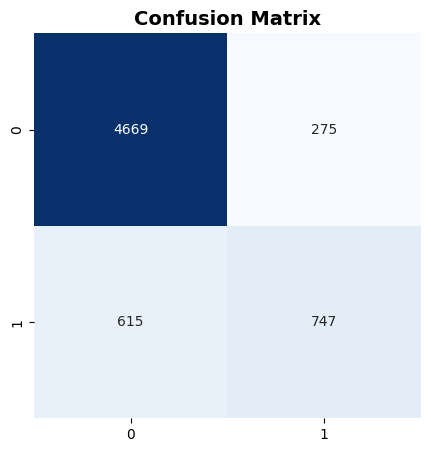

----------------------
AUC: 82.91%
----------------------


82.90631133303872

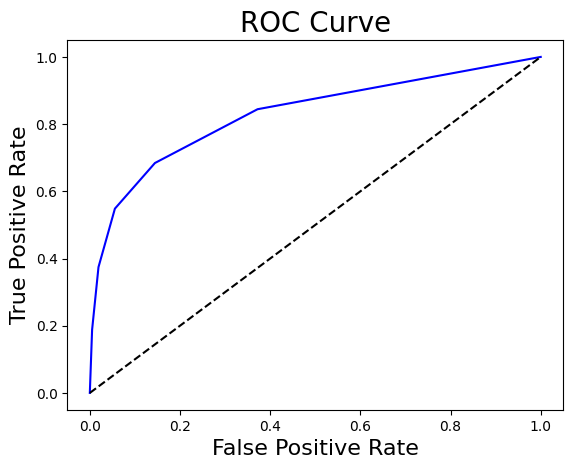

In [34]:
# KNN
knn_model = model['knn']
knn_model.fit(X_train, y_train)

knn_predictions = knn_model.predict(X_test)

predict_evaluation(knn_model, X_test, y_test)

roc_function(knn_model, X_test, y_test)

Accuracy predict: 84.44%
Precision: 72.28%
Recall: 45.37%
F1_score: 55.75%
----------------------
Сlassification report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      4944
           1       0.72      0.45      0.56      1362

    accuracy                           0.84      6306
   macro avg       0.79      0.70      0.73      6306
weighted avg       0.83      0.84      0.83      6306

----------------------
Confusion matrix:
[[4707  237]
 [ 744  618]]
----------------------


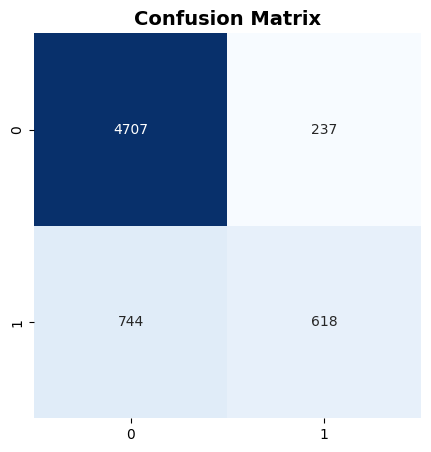

----------------------
AUC: 84.95%
----------------------


84.94938464992943

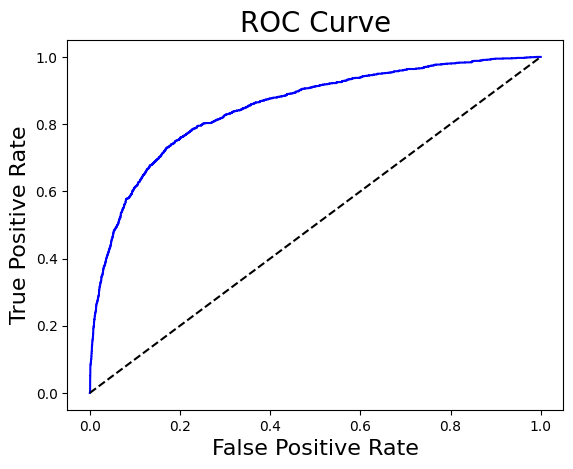

In [35]:
# Logistic Regression
logreg_model = model['logreg']

logreg_model.fit(X_train, y_train)

logreg_predictions = logreg_model.predict(X_test)

predict_evaluation(logreg_model, X_test, y_test)

roc_function(logreg_model, X_test, y_test)

Accuracy predict: 90.95%
Precision: 87.28%
Recall: 67.99%
F1_score: 76.43%
----------------------
Сlassification report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4944
           1       0.87      0.68      0.76      1362

    accuracy                           0.91      6306
   macro avg       0.89      0.83      0.85      6306
weighted avg       0.91      0.91      0.91      6306

----------------------
Confusion matrix:
[[4809  135]
 [ 436  926]]
----------------------


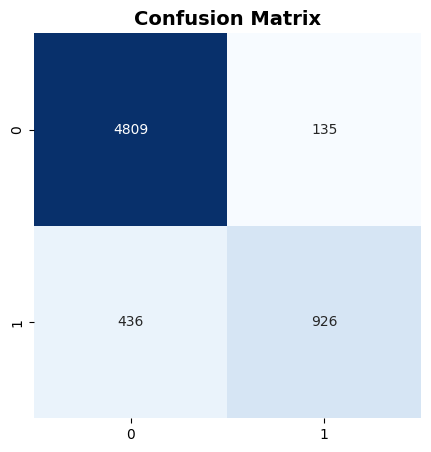

----------------------
AUC: 90.54%
----------------------


90.54163607440037

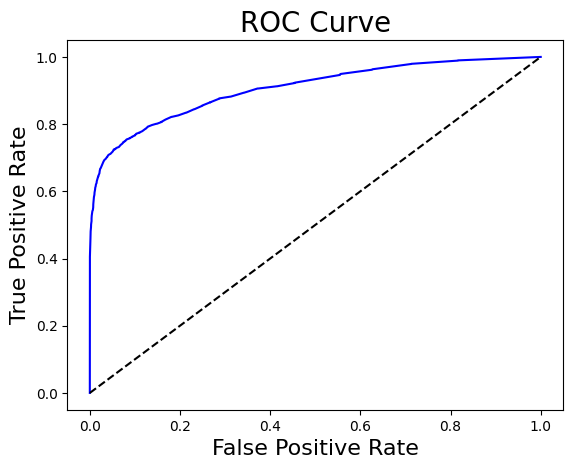

In [36]:
# Random Forest Classifier
rf_model = model['rf']

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

predict_evaluation(rf_model, X_test, y_test)

roc_function(rf_model, X_test, y_test)

cb_person_default_on_file              0.02
age_category                           0.02
cb_person_cred_hist_length_category    0.02
person_emp_length_category             0.03
loan_amnt_category                     0.03
person_income_category                 0.05
loan_intent                            0.10
person_home_ownership                  0.10
loan_grade                             0.13
loan_int_rate                          0.19
loan_percent_income                    0.31
dtype: float64


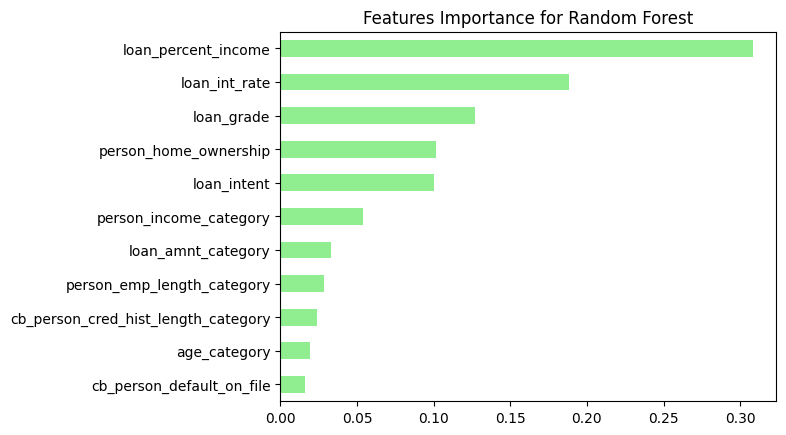

In [37]:
# Features Importance for Random Forest
importances_rf = pd.Series(rf_model.feature_importances_, index =X_train.columns).sort_values()
print(round(importances_rf,2))
importances_rf.plot(kind ="barh", color = "lightgreen")
plt.title("Features Importance for Random Forest")
plt.show()

Accuracy predict: 89.95%
Precision: 85.00%
Recall: 64.90%
F1_score: 73.61%
----------------------
Сlassification report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4944
           1       0.85      0.65      0.74      1362

    accuracy                           0.90      6306
   macro avg       0.88      0.81      0.84      6306
weighted avg       0.90      0.90      0.89      6306

----------------------
Confusion matrix:
[[4788  156]
 [ 478  884]]
----------------------


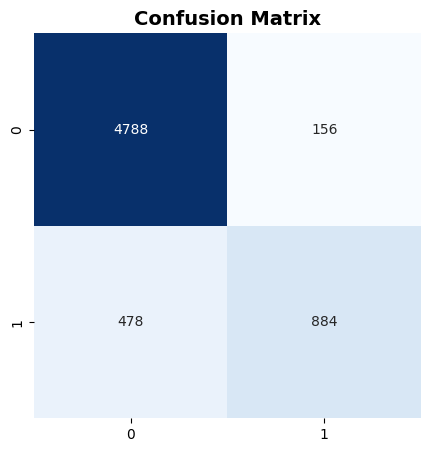

----------------------
AUC: 90.92%
----------------------


90.92006686340761

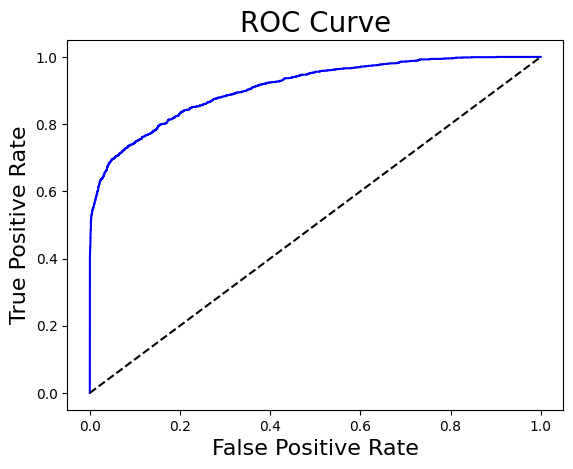

In [38]:
# Gradient Bossting
gb_model = model['gb']

gb_model.fit(X_train, y_train)

gb_predictions = gb_model.predict(X_test)

predict_evaluation(gb_model, X_test, y_test)

roc_function(gb_model, X_test, y_test)

cb_person_default_on_file              0.00
cb_person_cred_hist_length_category    0.00
age_category                           0.00
person_emp_length_category             0.00
loan_int_rate                          0.01
loan_amnt_category                     0.02
person_income_category                 0.04
loan_intent                            0.06
person_home_ownership                  0.20
loan_grade                             0.31
loan_percent_income                    0.35
dtype: float64


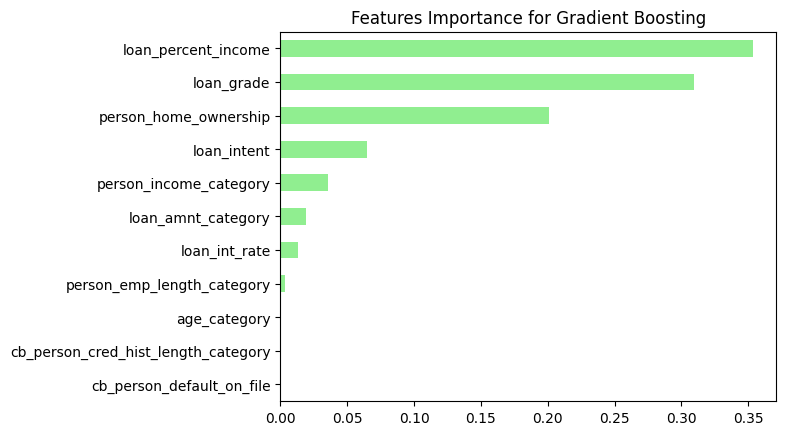

In [39]:
# Features Importance for Gradient Boosting
importances_gb = pd.Series(gb_model.feature_importances_, index =X_train.columns).sort_values()
print(round(importances_gb,2))
importances_gb.plot(kind ="barh", color = "lightgreen")
plt.title("Features Importance for Gradient Boosting")
plt.show()

Accuracy predict: 91.29%
Precision: 88.90%
Recall: 68.21%
F1_score: 77.19%
----------------------
Сlassification report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4944
           1       0.89      0.68      0.77      1362

    accuracy                           0.91      6306
   macro avg       0.90      0.83      0.86      6306
weighted avg       0.91      0.91      0.91      6306

----------------------
Confusion matrix:
[[4828  116]
 [ 433  929]]
----------------------


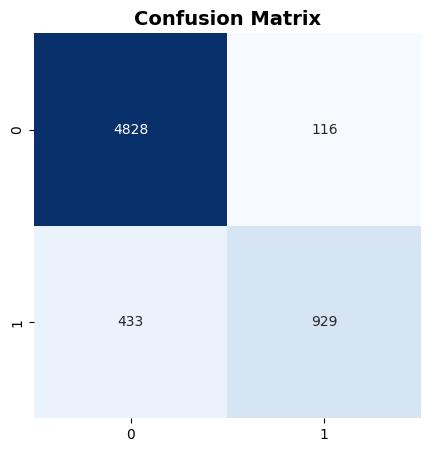

----------------------
AUC: 91.78%
----------------------


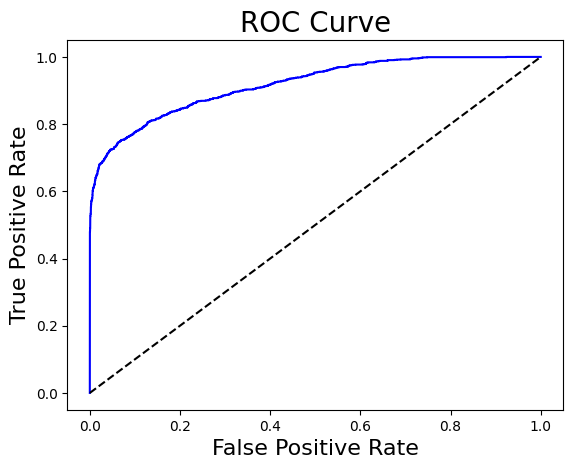

In [40]:
# Extreme Gradient Boosting (XG boost)
xgm_model = model['xgm']

xgm_model.fit(X_train, y_train)

xgm_predict = xgm_model.predict(X_test)

predict_evaluation(xgm_model, X_test, y_test)

xgm_auc = roc_function(xgm_model, X_test, y_test)

cb_person_default_on_file              0.02
age_category                           0.02
cb_person_cred_hist_length_category    0.02
loan_int_rate                          0.02
person_emp_length_category             0.03
loan_amnt_category                     0.04
person_income_category                 0.07
loan_intent                            0.07
loan_percent_income                    0.11
person_home_ownership                  0.23
loan_grade                             0.37
dtype: float32


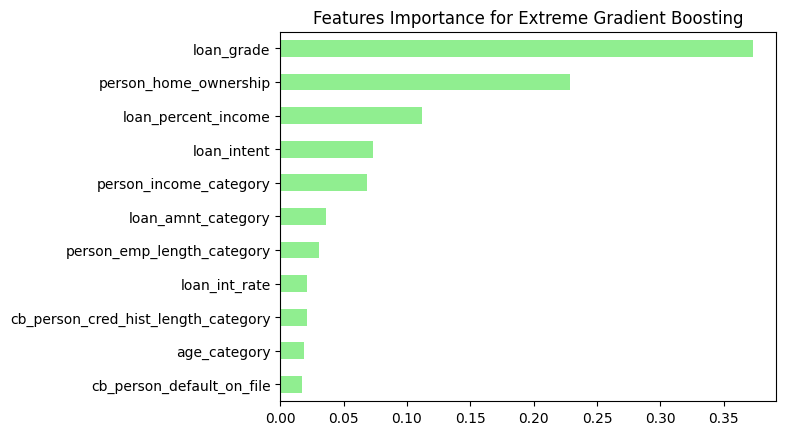

In [41]:
# Features Importance for XGBoost
importances_xgb = pd.Series(xgm_model.feature_importances_, index=X_train.columns).sort_values()
print(round(importances_xgb, 2))
importances_xgb.plot(kind="barh", color="lightgreen")
plt.title("Features Importance for Extreme Gradient Boosting")
plt.show()

Accuracy predict: 91.29%
Precision: 88.90%
Recall: 68.21%
F1_score: 77.19%
----------------------
Сlassification report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4944
           1       0.89      0.68      0.77      1362

    accuracy                           0.91      6306
   macro avg       0.90      0.83      0.86      6306
weighted avg       0.91      0.91      0.91      6306

----------------------
Confusion matrix:
[[4828  116]
 [ 433  929]]
----------------------


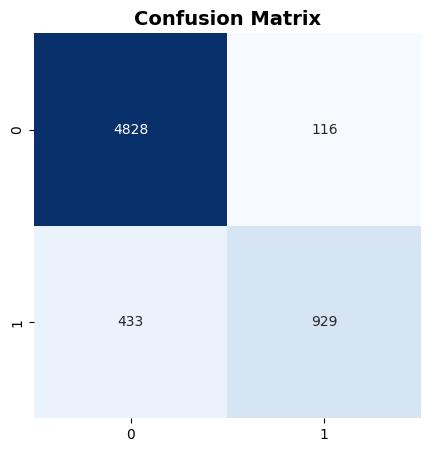

[array([0, 0, 0, ..., 0, 0, 0]), [0.9129400570884871, 0.8889952153110048, 0.6820851688693098, 0.7719152471956793]]


In [42]:
print(predict_evaluation(xgm_model, X_test, y_test))

In [43]:
# Model comparison

data = {
    'Model': ['KNN', 'Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Precision': [
        precision_score(y_test, knn_predictions) * 100,
        precision_score(y_test, logreg_predictions) * 100,
        precision_score(y_test, rf_predictions) * 100,
        precision_score(y_test, gb_predictions) * 100,
        precision_score(y_test, xgm_predict) * 100,
    ],
    'Accuracy': [
        accuracy_score(y_test, knn_predictions) * 100,
        accuracy_score(y_test, logreg_predictions) * 100,
        accuracy_score(y_test, rf_predictions) * 100,
        accuracy_score(y_test, gb_predictions) * 100,
        accuracy_score(y_test, xgm_predict) * 100,
    ],
     'Recall': [
        recall_score(y_test, knn_predictions) * 100,
        recall_score(y_test, logreg_predictions) * 100,
        recall_score(y_test, rf_predictions) * 100,
        recall_score(y_test, gb_predictions) * 100,
        recall_score(y_test, xgm_predict) * 100,
     ],
     'F1 score': [
        f1_score(y_test, knn_predictions) * 100,
        f1_score(y_test, logreg_predictions) * 100,
        f1_score(y_test, rf_predictions) * 100,
        f1_score(y_test, gb_predictions) * 100,
        f1_score(y_test, xgm_predict) * 100,
     ],
    'AUC': [
        roc_auc_score(y_test, knn_model.predict_proba(X_test)[:, 1]) * 100,
        roc_auc_score(y_test, logreg_model.predict_proba(X_test)[:, 1]) * 100,
        roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]) * 100,
        roc_auc_score(y_test, gb_model.predict_proba(X_test)[:, 1]) * 100,
        roc_auc_score(y_test, xgm_model.predict_proba(X_test)[:, 1]) * 100
    ]
}

df_results = pd.DataFrame(data)
df_results

,Model,Precision,Accuracy,Recall,F1 score,AUC
0,KNN,73.091977,85.886457,54.845815,62.667785,82.906311
1,Logistic Regression,72.280702,84.443387,45.374449,55.751015,84.949385
2,Random Forest,87.276155,90.945132,67.988253,76.434173,90.541636
3,Gradient Boosting,85.000000,89.946083,64.904552,73.605329,90.920067
4,XGBoost,88.899522,91.294006,68.208517,77.191525,91.783341


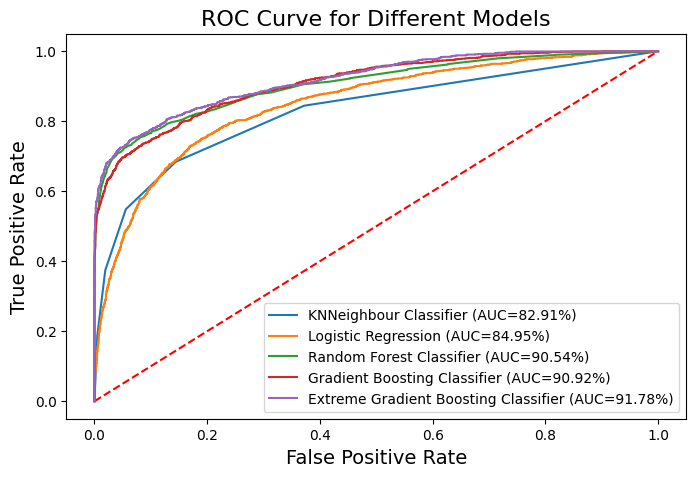

In [44]:
# Plot ROC curve with AUC values for all models to compare
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot([0, 1], [0, 1], 'r--')

models = [knn_model, logreg_model, rf_model, gb_model, xgm_model]

names_best_models = ["KNNeighbour Classifier", "Logistic Regression", "Random Forest Classifier", "Gradient Boosting Classifier","Extreme Gradient Boosting Classifier"]

for i,k in enumerate(models):
    y_predict_proba = k.predict_proba(X_test)[:, 1]
    fpr_, tpr_, _ = roc_curve(y_test, y_predict_proba)
    auc_ = roc_auc_score(y_test, y_predict_proba)
    ax.plot(fpr_, tpr_, label=f'{names_best_models[i]} (AUC={auc_*100:.2f}%)')
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.title("ROC Curve for Different Models",fontsize=16)
    plt.legend()
plt.show()

Observation: Based on the metrics comparison, we can draw the following conclusions:

*   The Random Forest Classifier and XGBoost models have the highest accuracy,
with values of 90.94% and 91.29%, respectively.These models outperform the other models.
*   The XGBoost model has the highest precision with value of 91.78%. This indicates that XGBoost is better at correctly identifying positive cases (i.e., individuals who will default on their loans).

*   The XGBoost model has the highest recall, with a value of 68.20%. This indicates that XGboost is also better at identifying all instances of defaulting individuals.
*   The XGBoost model has the highest F1-score, with a value of 71.19%. This suggests that XGBoost provides a good balance between precision and recall.
* The Gradient Boosting(GB) and XGBoost models provide a good balance between accuracy, precision, recall, and F1-score
* The XGBoost model has the highest AUC value - 91.68%. This indicates that the model is able to correctly rank instances in order of their probability of defaulting on their loans, with a higher AUC value indicating better performance.


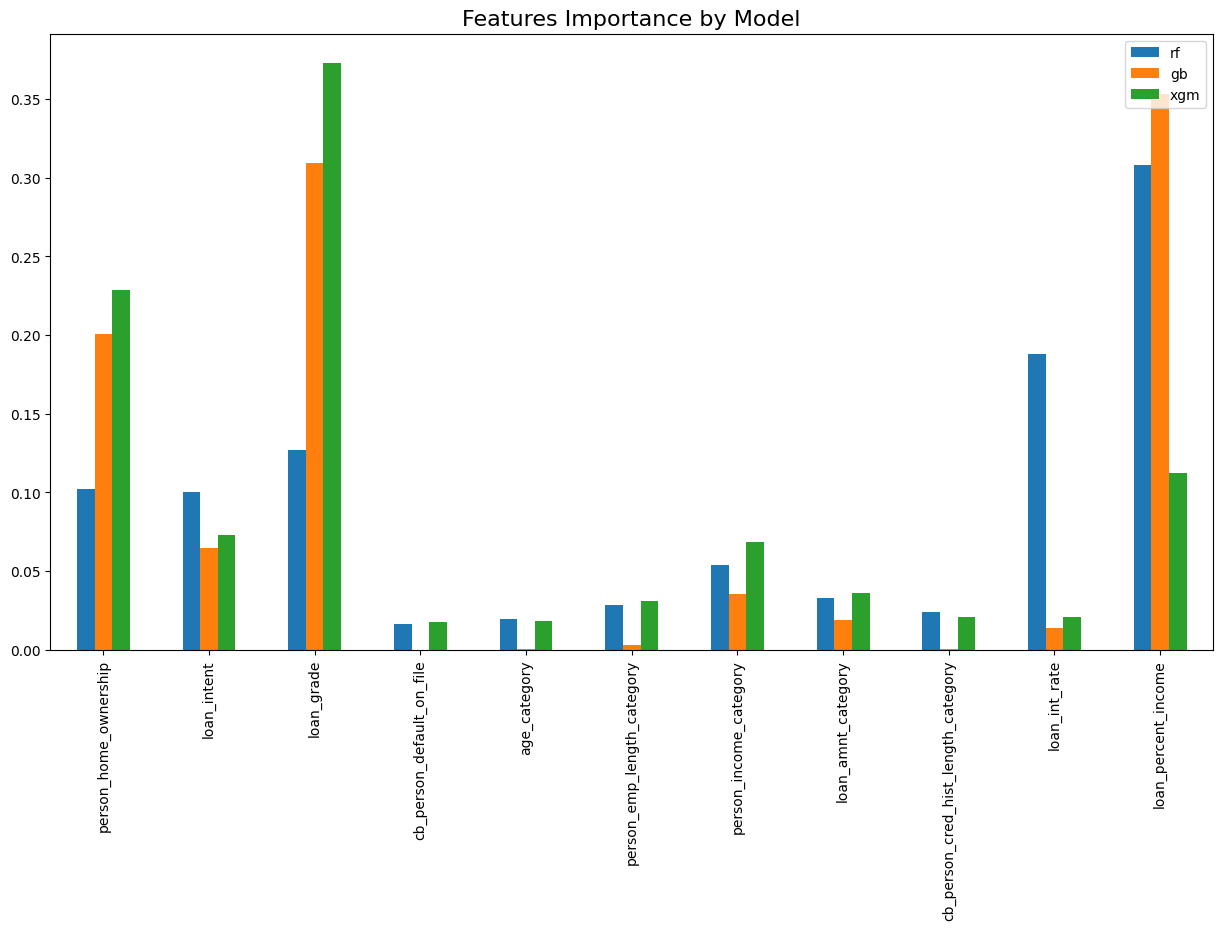

In [45]:
# Feature Comparison
importance_df = pd.DataFrame()
importance_df["rf"]=pd.Series(rf_model.feature_importances_, index =X_train.columns)
importance_df["gb"] = pd.Series(gb_model.feature_importances_, index =X_train.columns)
importance_df["xgm"]= pd.Series(xgm_model.feature_importances_, index =X_train.columns)

fig, ax = plt.subplots(figsize=(15, 8))
importance_df.plot.bar( stacked = False, ax=ax)
ax.set_title('Features Importance by Model', fontsize=16)
ax.legend(loc='upper right')
plt.show()


Key Observations:

1. **`loan_grade`**:
   - Most important feature for **XGBoost** (importance ≈ 0.35).
   - Second highest for **Gradient Boosting** (importance ≈ 0.30).
   - Comparatively lower importance for **Random Forest** (importance ≈ 0.20).

2. **`loan_percent_income`**:
   - Most important for **Gradient Boosting** (importance ≈ 0.35).
   - Second highest for **Random Forest** (importance ≈ 0.30).
   - Lower importance for **XGBoost** (importance ≈ 0.20).

3. **`person_home_ownership`**:
   - High importance for all models, with:
     - **XGBoost** having the highest (importance ≈ 0.22).
     - **Gradient Boosting** close behind (importance ≈ 0.20).
     - **Random Forest** slightly lower (importance ≈ 0.18).

4. **`loan_intent`**:
   - Similar importance across models:
     - **XGBoost** (importance ≈ 0.12).
     - **Gradient Boosting** (importance ≈ 0.10).
     - **Random Forest** (importance ≈ 0.08).

5. **`loan_int_rate`**:
   - Highest for **Random Forest** (importance ≈ 0.25).
   - Minimal importance for other models (< 0.05).

6. Features like **`cb_person_default_on_file`**, **`age_category`**, and **`cb_person_cred_hist_length_category`** have negligible importance (< 0.05) across all models.

The graph reveals that the importance of features varies significantly depending on the model. Features such as `loan_grade` and `loan_percent_income` consistently have high importance across most models, while others like `cb_person_default_on_file` are generally insignificant.